In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display_html

In [2]:
path = 'enem_small_data/'
file = 'Microdados_ENEM_Amostra_'

In [3]:
# Copiei do stack overflow temporariamente

def display_dfs(dfs, names=[]):
    html_str = ''
    if names:
        html_str += ('<tr>' + 
                     ''.join(f'<td style="text-align:center">{name}</td>' for name in names) + 
                     '</tr>')
    html_str += ('<tr>' + 
                 ''.join(f'<td style="vertical-align:top"> {df.head().to_html(index=False)}</td>' 
                         for df in dfs) + 
                 '</tr>')
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

In [4]:
plt.ion()
plt.rcParams['figure.figsize']  = (8, 5)

In [145]:
df = pd.read_csv(path+file+'2018.csv', sep=',',  encoding='latin-1', usecols=[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'NU_IDADE', 'CO_UF_RESIDENCIA',
    'TP_SEXO', 'TP_COR_RACA', 'Q001', 'Q002', 'Q006', 'Q025', 'Q027', 'TP_DEPENDENCIA_ADM_ESC']).dropna()
df.loc[:,'Media'] = df[['NU_NOTA_CN', 'NU_NOTA_CH',
                                'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].sum(axis=1)/len(df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].columns)

#codificando atributos categóricos
'''
dfCorr['Q001'] = [ord(x) - 64 for x in dfCorr['Q001']]
dfCorr['Q002'] = [ord(x) - 64 for x in dfCorr['Q002']]
dfCorr['Q006'] = [ord(x) - 64 for x in dfCorr['Q006']]
dfCorr['Q025'] = [ord(x) - 64 for x in dfCorr['Q025']]
sexo = {'M': 1, 'F': 2}
dfCorr['TP_SEXO'] = [sexo[x] for x in dfCorr['TP_SEXO']]
'''
encoder = preprocessing.LabelEncoder()
df['Q001'] = encoder.fit_transform(df['Q001'])
df['Q002'] = encoder.fit_transform(df['Q002'])
df['Q006'] = encoder.fit_transform(df['Q006'])
df['Q025'] = encoder.fit_transform(df['Q025'])
df['Q027'] = encoder.fit_transform(df['Q027'])
df['TP_SEXO'] = encoder.fit_transform(df['TP_SEXO'])
df['CO_UF_RESIDENCIA'] = encoder.fit_transform(df['CO_UF_RESIDENCIA'])

df.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q025,Q027,Media
2,20,17,0,1,2.0,417.4,481.5,496.5,504.3,320.0,3,5,7,1,0,443.94
7,9,17,0,3,2.0,390.9,600.5,598.7,564.5,480.0,7,1,1,0,1,526.92
11,9,18,0,3,2.0,521.8,602.7,532.8,486.3,440.0,4,4,2,1,0,516.72
13,16,17,0,3,4.0,640.8,659.4,606.0,736.9,800.0,4,4,6,1,3,688.62
28,12,18,0,3,2.0,475.6,432.9,507.7,420.5,300.0,2,4,2,1,0,427.34


In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

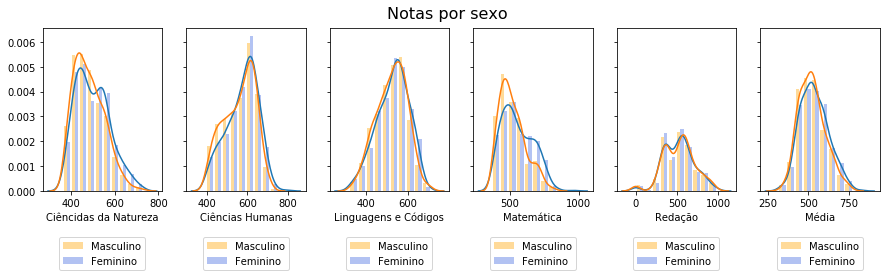

In [134]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['TP_SEXO'] == 0][columns[i]],df[df['TP_SEXO'] == 1][columns[i]]], 
                 label=['Masculino', 'Feminino'], density=True, color=['orange','royalblue'], alpha=0.4)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
    
    sns.distplot(df[df['TP_SEXO'] == 1][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['TP_SEXO'] == 0][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Notas por sexo'), fontsize=16)
plt.show()


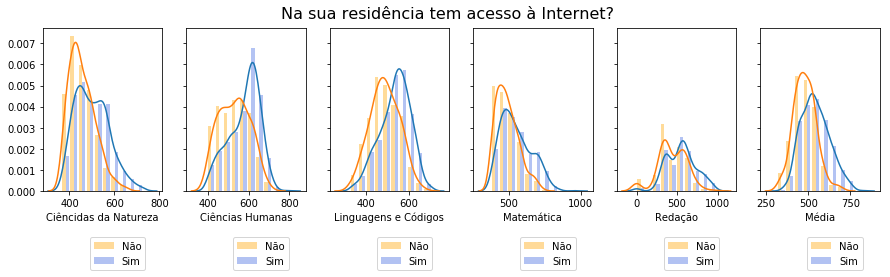

In [135]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['Q025'] == 0][columns[i]],df[df['Q025'] == 1][columns[i]]], 
                 label=['Não', 'Sim'], density=True, color=['orange','royalblue'], alpha=0.4)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
        
    sns.distplot(df[df['Q025'] == 1][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['Q025'] == 0][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Na sua residência tem acesso à Internet?'), fontsize=16)
plt.show()


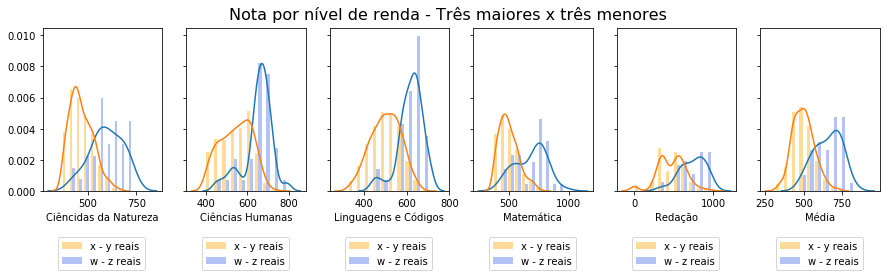

In [136]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True)
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    axes[i].hist([df[df['Q006'].isin([0, 1, 2])][columns[i]],df[df['Q006'].isin([14, 15, 16])][columns[i]]], 
                 label=['x - y reais', 'w - z reais'], density=True, color=['orange','royalblue'], alpha=0.4)
    axes[i].legend(loc='best',  bbox_to_anchor=(0.9, -0.25))
    
    sns.distplot(df[df['Q006'].isin([14, 15, 16])][columns[i]], hist = False, ax=axes[i])
    sns.distplot(df[df['Q006'].isin([0, 1, 2])][columns[i]], hist = False, ax=axes[i], axlabel=labels[i])
fig.suptitle(('Nota por nível de renda - Três maiores x três menores'), fontsize=16)
plt.show()

### Tentativa de regressão

In [137]:
df = pd.read_csv(path+file+'2018.csv', sep=',',  encoding='latin-1', usecols=[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'NU_IDADE', 'CO_UF_RESIDENCIA',
    'TP_SEXO', 'TP_COR_RACA', 'Q001', 'Q002', 'Q006', 'Q025', 'Q027', 'TP_DEPENDENCIA_ADM_ESC']).dropna()
df.loc[:,'Media'] = df[['NU_NOTA_CN', 'NU_NOTA_CH',
                                'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].sum(axis=1)/len(df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO']].columns)

X = df.drop(columns=['Media','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO'])
y = df['Media'].copy()
X.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_DEPENDENCIA_ADM_ESC,Q001,Q002,Q006,Q025,Q027
2,41,17,F,1,2.0,D,F,H,B,A
7,23,17,F,3,2.0,H,B,B,A,B
11,23,18,F,3,2.0,E,E,C,B,A
13,31,17,F,3,4.0,E,E,G,B,D
28,26,18,F,3,2.0,C,E,C,B,A


In [138]:
encoder = preprocessing.OrdinalEncoder()
ohencoder = preprocessing.OneHotEncoder(sparse=False, categories='auto')

#Aplicando one hot enconding às variáveis categóricas
X_enc = encoder.fit_transform(X.drop(columns=['NU_IDADE', 'Q006']))
X_enc = ohencoder.fit_transform(X_enc)

#Adicionando idade(numérica) e renda (categórica ordinal)
renda = encoder.fit_transform(X[['Q006']])
X_enc = np.hstack((X_enc, renda, X[['NU_IDADE']])) 


X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.5, random_state=42)

In [139]:
reg = LinearRegression().fit(X_train, y_train)

In [140]:
y_predict = reg.predict(X_test)

In [141]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_predict))

Variance score: 0.33


## ------------------------------ Só mexi até aqui ---------------------------------

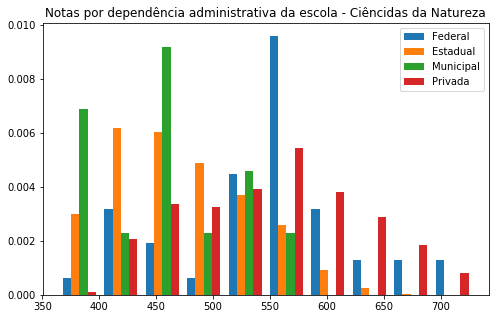

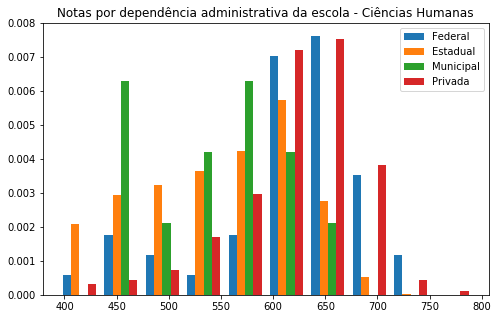

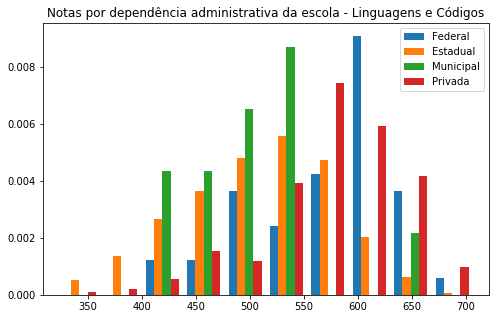

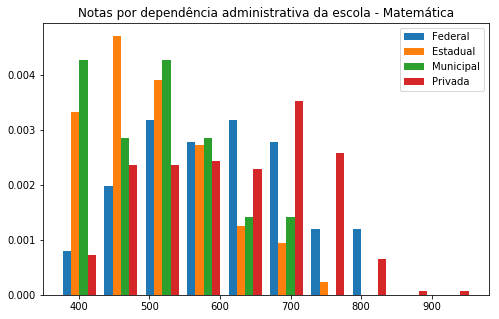

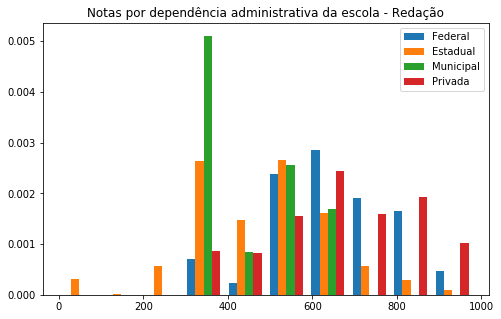

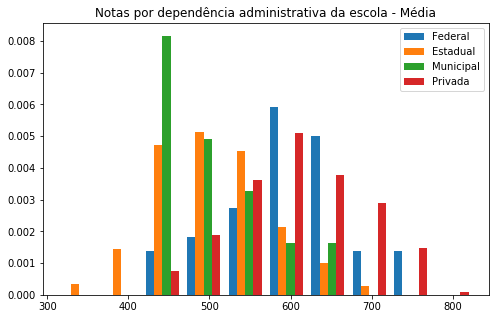

In [12]:
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    plt.hist([dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 1][columns[i]],dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 2][columns[i]], 
             dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 3][columns[i]],dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 4][columns[i]]],
             label=['Federal', 'Estadual', 'Municipal', 'Privada'], density=True)
    plt.legend(loc='upper right')
    plt.title('Notas por dependência administrativa da escola - '+labels[i])
    #plt.xlim(700, 1000)
    plt.show()
    


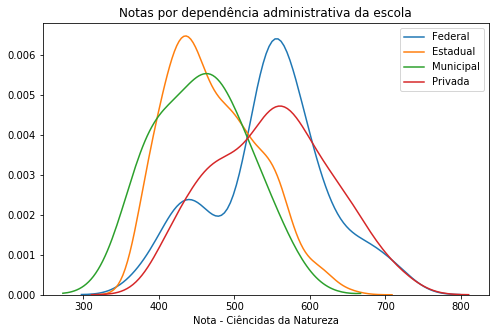

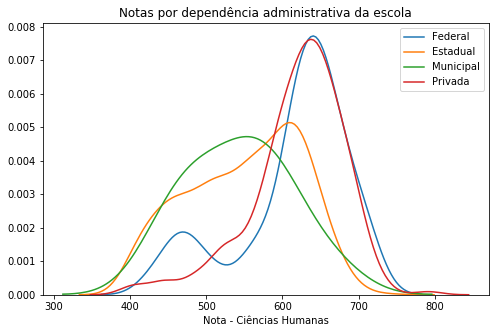

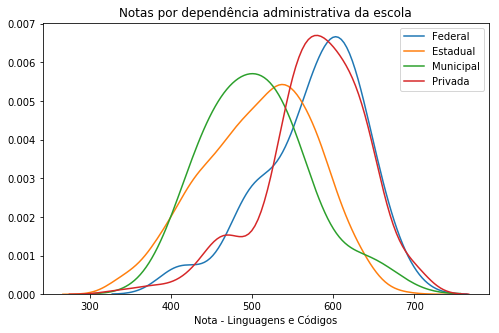

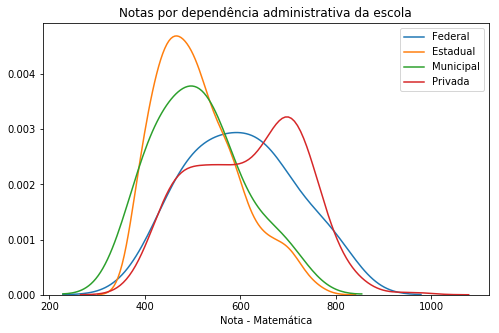

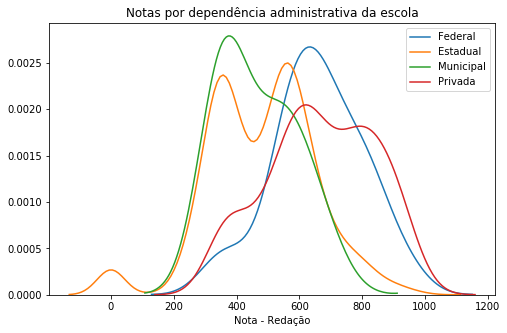

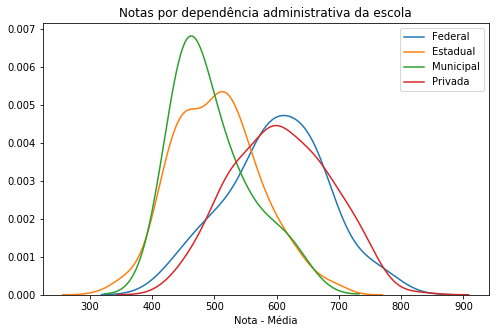

In [13]:
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    plt.title('Notas por dependência administrativa da escola')
    sns.distplot(dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 1][columns[i]], hist = False, label = 'Federal')
    sns.distplot(dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 2][columns[i]], hist = False, label = 'Estadual')
    sns.distplot(dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 3][columns[i]], hist = False, label = 'Municipal')
    sns.distplot(dfCorr[dfCorr['TP_DEPENDENCIA_ADM_ESC'] == 4][columns[i]], hist = False, label = 'Privada')
    plt.xlabel('Nota - ' + labels[i])
    plt.show()

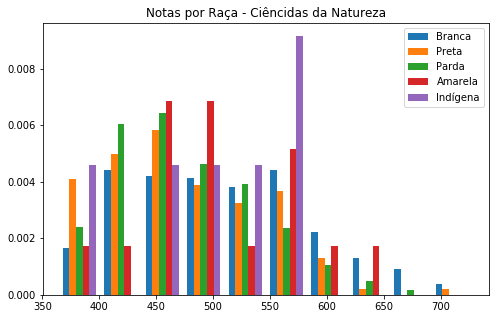

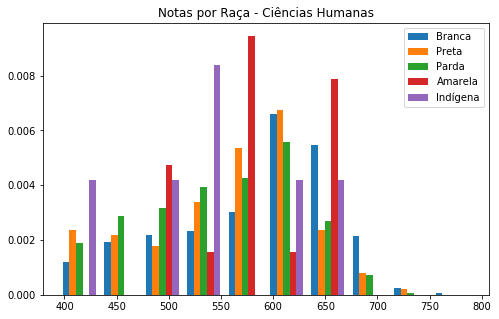

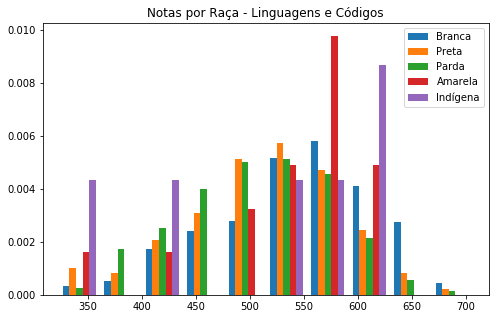

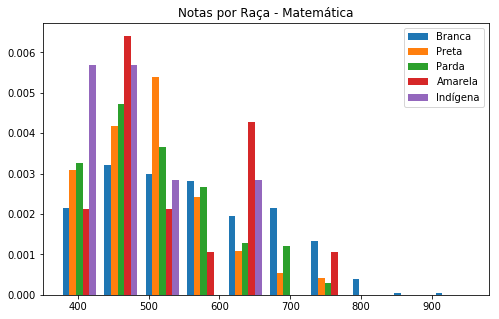

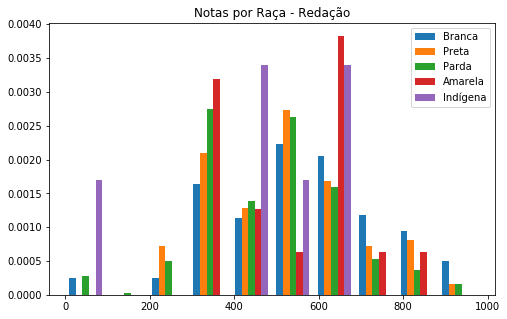

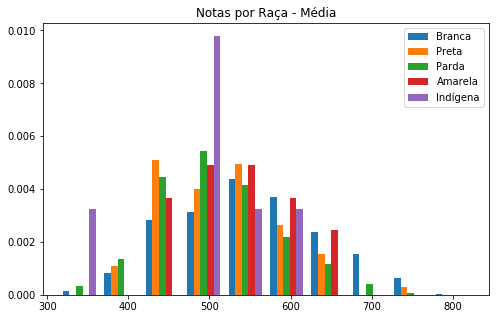

In [14]:
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    plt.hist([dfCorr[dfCorr['TP_COR_RACA'] == 1][columns[i]],dfCorr[dfCorr['TP_COR_RACA'] == 2][columns[i]],
             dfCorr[dfCorr['TP_COR_RACA'] == 3][columns[i]], dfCorr[dfCorr['TP_COR_RACA'] == 4][columns[i]], 
             dfCorr[dfCorr['TP_COR_RACA'] == 5][columns[i]]], label=['Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'], density=True)
    plt.legend(loc='upper right')
    plt.title('Notas por Raça - '+ labels[i])
    plt.show()


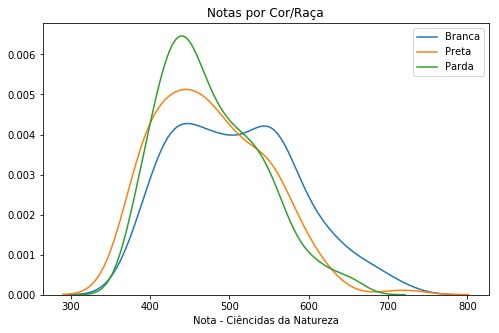

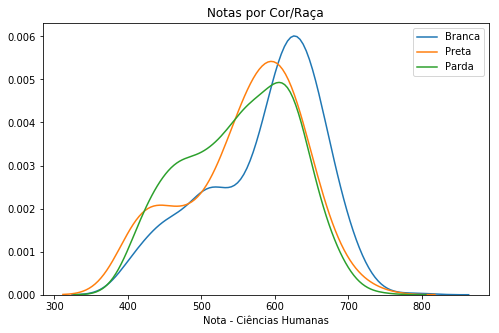

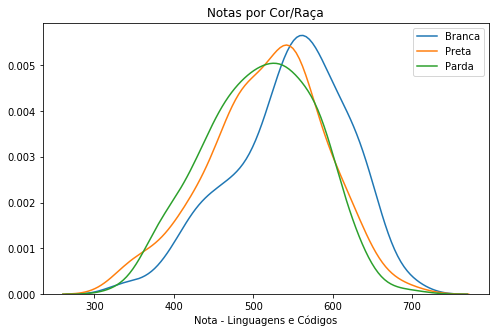

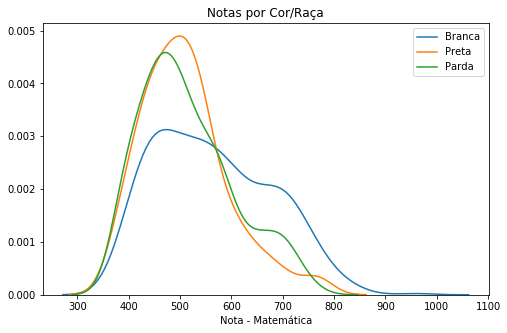

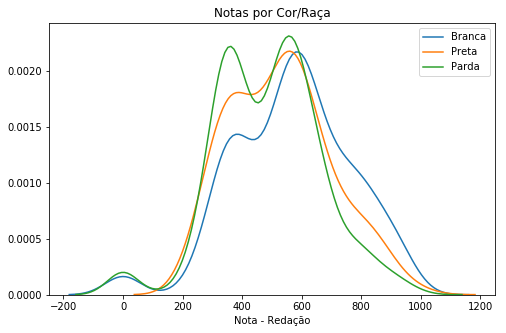

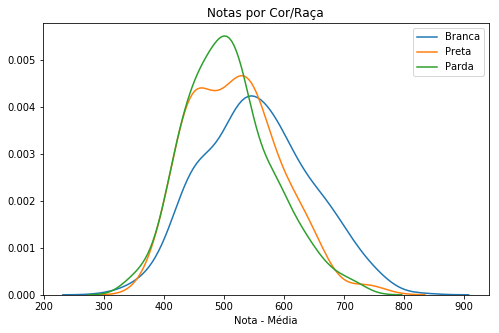

In [15]:
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    plt.title('Notas por Cor/Raça')
    sns.distplot(dfCorr[dfCorr['TP_COR_RACA'] == 1][columns[i]], hist = False, label = 'Branca')
    sns.distplot(dfCorr[dfCorr['TP_COR_RACA'] == 2][columns[i]], hist = False, label = 'Preta')
    sns.distplot(dfCorr[dfCorr['TP_COR_RACA'] == 3][columns[i]], hist = False, label = 'Parda')
    #sns.distplot(dfCorr[dfCorr['TP_COR_RACA'] == 4][columns[i]], hist = False, label = 'Amarela')
    #sns.distplot(dfCorr[dfCorr['TP_COR_RACA'] == 5][columns[i]], hist = False, label = 'Indígena')
    plt.xlabel('Nota - ' + labels[i])
    plt.show()

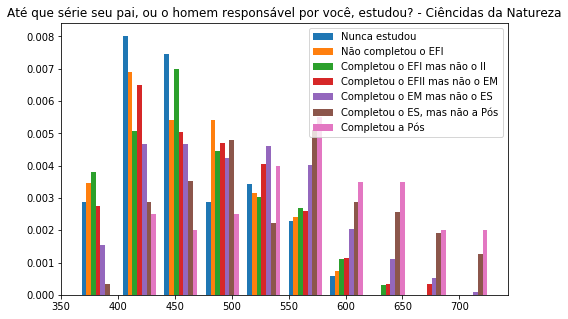

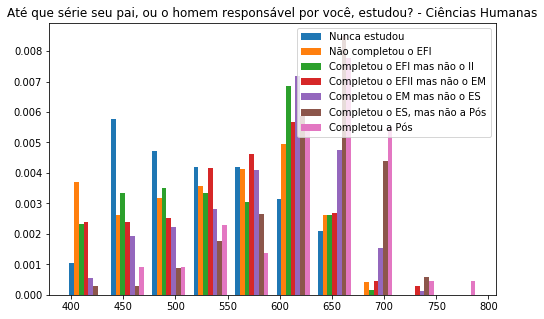

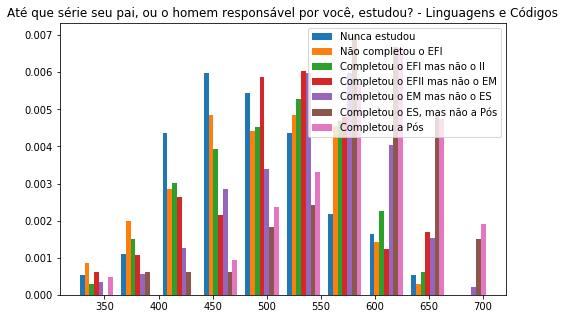

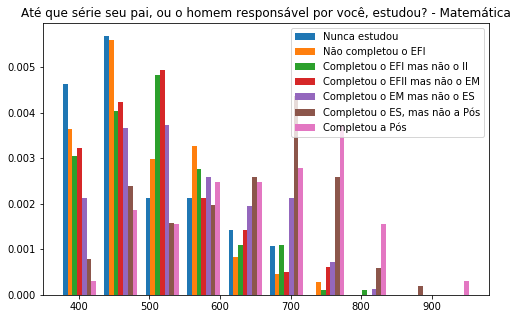

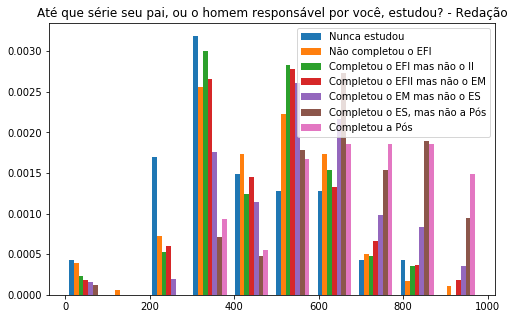

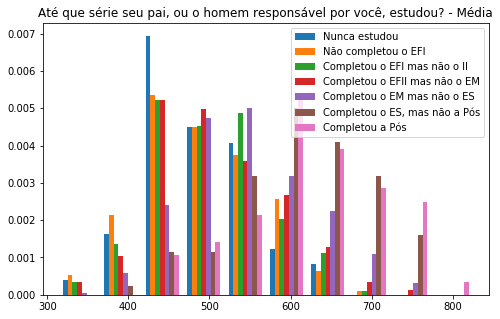

In [16]:
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    plt.hist([dfCorr[dfCorr['Q001'] == 1][columns[i]],dfCorr[dfCorr['Q001'] == 2][columns[i]],
             dfCorr[dfCorr['Q001'] == 3][columns[i]], dfCorr[dfCorr['Q001'] == 4][columns[i]], 
             dfCorr[dfCorr['Q001'] == 5][columns[i]], dfCorr[dfCorr['Q001'] == 6][columns[i]], 
             dfCorr[dfCorr['Q001'] == 7][columns[i]]], label=['Nunca estudou',  'Não completou o EFI',  'Completou o EFI mas não o II', 'Completou o EFII mas não o EM', 'Completou o EM mas não o ES', 'Completou o ES, mas não a Pós', 'Completou a Pós'], density=True)
    plt.legend(loc='upper right')
    plt.title('Até que série seu pai, ou o homem responsável por você, estudou? - '+ labels[i])
    plt.show()


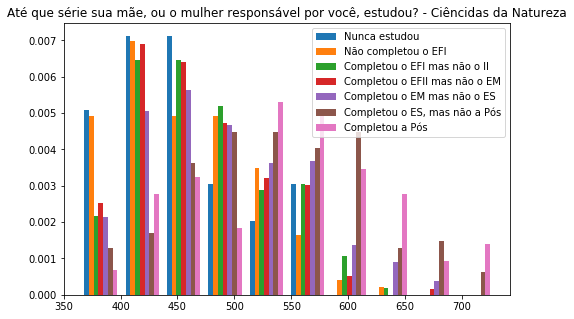

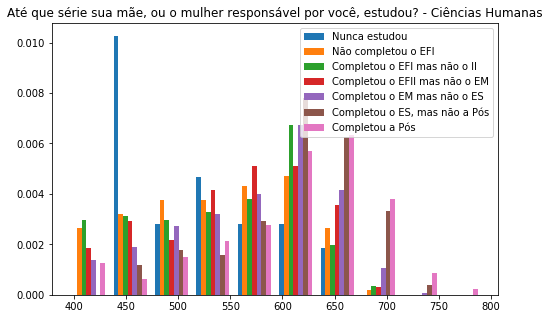

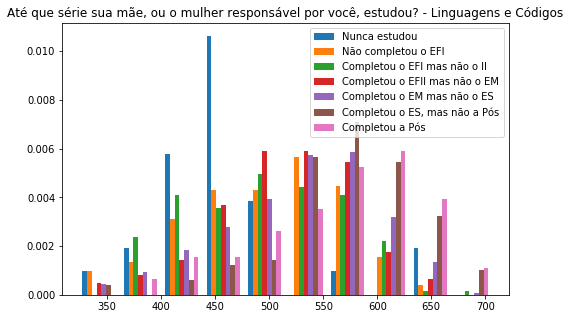

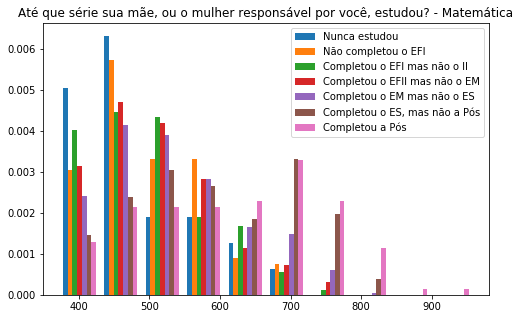

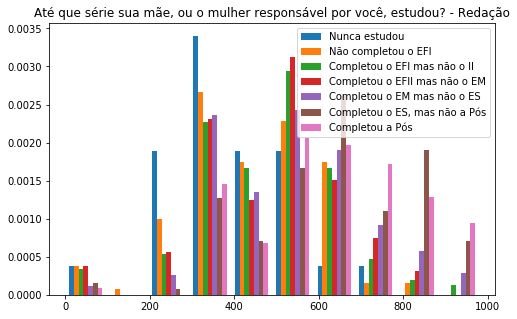

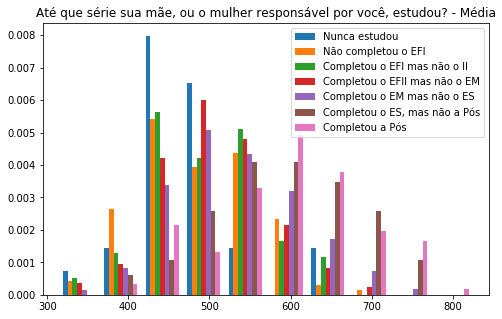

In [17]:
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    plt.hist([dfCorr[dfCorr['Q002'] == 1][columns[i]],dfCorr[dfCorr['Q002'] == 2][columns[i]],
             dfCorr[dfCorr['Q002'] == 3][columns[i]], dfCorr[dfCorr['Q002'] == 4][columns[i]], 
             dfCorr[dfCorr['Q002'] == 5][columns[i]], dfCorr[dfCorr['Q002'] == 6][columns[i]], 
             dfCorr[dfCorr['Q002'] == 7][columns[i]]], label=['Nunca estudou',  'Não completou o EFI',  'Completou o EFI mas não o II', 'Completou o EFII mas não o EM', 'Completou o EM mas não o ES', 'Completou o ES, mas não a Pós', 'Completou a Pós'], density=True)
    plt.legend(loc='upper right')
    plt.title('Até que série sua mãe, ou o mulher responsável por você, estudou? - '+ labels[i])
    plt.show()


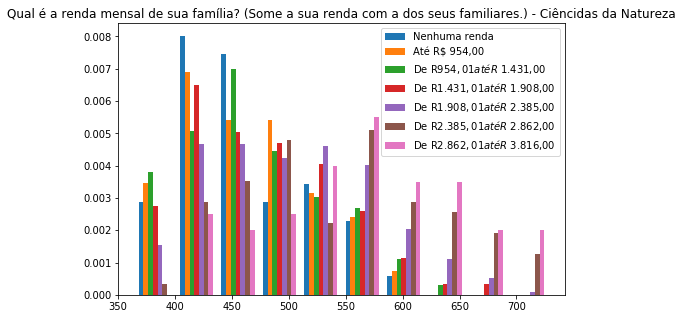

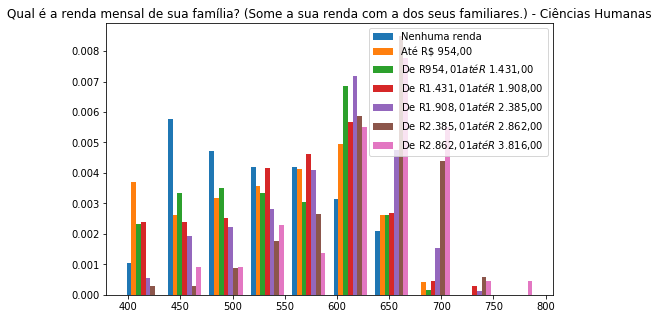

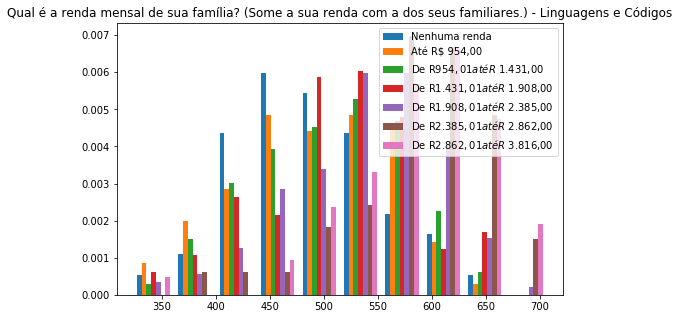

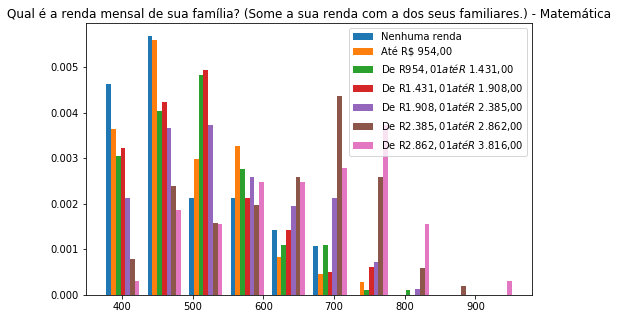

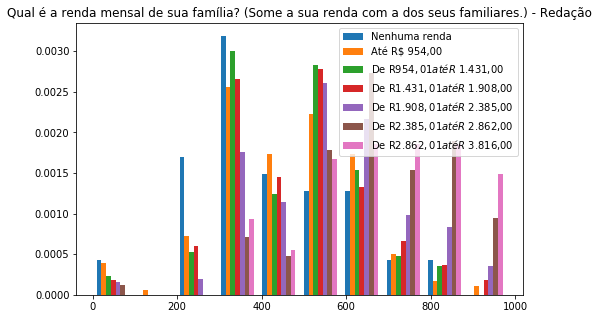

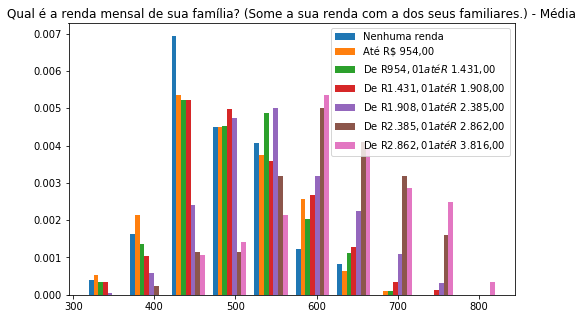

In [18]:
labels = ['Ciêncidas da Natureza', 'Ciências Humanas', 'Linguagens e Códigos', 'Matemática', 'Redação', 'Média']
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_REDACAO', 'Media']
for i in range(len(columns)):
    plt.hist([dfCorr[dfCorr['Q001'] == 1][columns[i]],dfCorr[dfCorr['Q001'] == 2][columns[i]],
             dfCorr[dfCorr['Q001'] == 3][columns[i]], dfCorr[dfCorr['Q001'] == 4][columns[i]], 
             dfCorr[dfCorr['Q001'] == 5][columns[i]], dfCorr[dfCorr['Q001'] == 6][columns[i]], 
             dfCorr[dfCorr['Q001'] == 7][columns[i]]], label=['Nenhuma renda', 'Até R$ 954,00', 'De R$ 954,01 até R$ 1.431,00', 'De R$ 1.431,01 até R$ 1.908,00', 'De R$ 1.908,01 até R$ 2.385,00', 'De R$ 2.385,01 até R$ 2.862,00', 'De R$ 2.862,01 até R$ 3.816,00', 'De R$ 3.816,01 até R$ 4.770,00', 'De R$ 4.770,01 até R$ 5.724,00', 'De R$ 5.724,01 até R$ 6.678,00', 'De R$ 6.678,01 até R$ 7.632,00', 'De R$ 7.632,01 até R$ 8.586,00', 'De R$ 8.586,01 até R$ 9.540,00', 'De R$ 9.540,01 até R$ 11.448,00', 'De R$ 11.448,01 até R$ 14.310,00', 'De R$ 14.310,01 até R$ 19.080,00', 'Mais de R$ 19.080,00'], density=True)
    plt.legend(loc='upper right')
    plt.title('Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.) - '+ labels[i])
    plt.show()
